In [3]:
import numpy as np
import os
import h5py
import tables
from scipy.io import loadmat

from keras.preprocessing import image

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcudnn.so.6: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [5]:
!CUDNNPATH="/lustre/shared/caffe_shared/cuda_stuff/cudnnn-6.0_for_cuda8"

!export LD_LIBRARY_PATH=${CUDNNPATH}/lib64:$LD_LIBRARY_PATH

In [6]:
!echo $LD_LIBRARY_PATH

/lustre/shared/caffe_shared/cuda_stuff/cuda-8.0.27.1_RC/lib64:/lustre/shared/caffe_shared/cuda_stuff/cudnn-5.1_for_cuda8.0rc/lib64:


In [2]:
from keras.preprocessing import image

pascal3d_path = '/home/sprokudin/biternionnet/data/PASCAL3D+_release1.1'

def get_imagenet_data(pascal3d_path, class_name):

    
    def _load_image(img_path):

        img = image.load_img(img_path, target_size=(224, 224))
        x = np.asarray(img)

        return x 
    
    def _parse_annotation(mat_path):
    
        ann = loadmat(mat_path)

        cls_name = ann['record'][0][0][1][0][0][0]
        # bbox = ann['record'][0][0][1][0][0][1]
        viewpoint = ann['record'][0][0][1][0][0][3][0][0]

        azimuth = viewpoint[2]
        elevation = viewpoint[3]
        tilt = viewpoint[8]
        #distance =  viewpoint[4]

        #viewpoint = np.asarray([azimuth, elevation, distance])

        return azimuth, elevation
    
    #ann_path_pascal = os.path.join(pascal3d_path, 'Annotations/%s_pascal/'%class_name)
    ann_path_imagenet = os.path.join(pascal3d_path, 'Annotations/%s_imagenet/'%class_name)
    #imgs_path_pascal =os.path.join(pascal3d_path, 'Images/%s_pascal/'%class_name)
    imgs_path_imagenet = os.path.join(pascal3d_path, 'Images/%s_imagenet/'%class_name)   
    
    #pascal_annotations = os.listdir(ann_path_pascal)
    #pascal_images_fpath = [os.path.join(imgs_path_pascal, ann.split('.')[0]+'.jpg') for ann in pascal_annotations]
    #pascal_annotations_fpath = [os.path.join(ann_path_pascal, ann) for ann in pascal_annotations]

    imagenet_annotations = os.listdir(ann_path_imagenet)
    imagenet_images_fpath = [os.path.join(imgs_path_imagenet, ann.split('.')[0]+'.JPEG') for ann in imagenet_annotations]
    imagenet_annotations_fpath = [os.path.join(ann_path_imagenet, ann) for ann in imagenet_annotations]

    labels = np.zeros([len(imagenet_annotations), 3])
    images = np.zeros([len(imagenet_annotations), 224, 224, 3], dtype='uint8')

    for i in range(0, len(imagenet_annotations)):
        azimuth, elevation = _parse_annotation(imagenet_annotations_fpath[i])
        labels[i, 0] = azimuth
        labels[i, 1] = elevation
        images[i] = _load_image(imagenet_images_fpath[i])
        if i%50 == 0 :
            print("parsed %d samples.."% i)
    
    azimuth_deg =  labels[:, 0]
    elevation_deg =  labels[:, 1]
    tilt_deg =  labels[:, 2]

    data = {'images': images,
            'azimuth_deg': azimuth_deg.reshape([-1, 1]),
            'azimuth_bit': deg2bit(azimuth_deg),
            'elevation_deg': elevation_deg.reshape([-1, 1]),
            'elevation_bit': deg2bit(elevation_deg),
            'tilt_deg': tilt_deg.reshape([-1, 1]),
            'tilt_bit': deg2bit(tilt_deg)}
    
    return data

In [3]:
from utils.angles import bit2deg, deg2bit
imagenet_train_data = get_imagenet_data(pascal3d_path, 'aeroplane')

parsed 0 samples..
parsed 50 samples..
parsed 100 samples..
parsed 150 samples..
parsed 200 samples..
parsed 250 samples..
parsed 300 samples..
parsed 350 samples..
parsed 400 samples..
parsed 450 samples..
parsed 500 samples..
parsed 550 samples..
parsed 600 samples..
parsed 650 samples..
parsed 700 samples..
parsed 750 samples..
parsed 800 samples..
parsed 850 samples..
parsed 900 samples..
parsed 950 samples..
parsed 1000 samples..
parsed 1050 samples..
parsed 1100 samples..
parsed 1150 samples..
parsed 1200 samples..
parsed 1250 samples..
parsed 1300 samples..
parsed 1350 samples..
parsed 1400 samples..
parsed 1450 samples..
parsed 1500 samples..
parsed 1550 samples..
parsed 1600 samples..
parsed 1650 samples..
parsed 1700 samples..
parsed 1750 samples..
parsed 1800 samples..
parsed 1850 samples..
parsed 1900 samples..
parsed 1950 samples..


In [4]:
from utils.angles import bit2deg, deg2bit

def stitch_data_dicts(real_dict, syn_dict):

    stitched = {}
    for key in real_dict.keys():    
        stitched[key] = np.vstack([real_dict[key], syn_dict[key]])

    return stitched

def train_val_split(data, val_split=0.1):

    n_samples = len(data['images'])

    shuffled_samples = np.random.choice(n_samples, n_samples, replace=False)
    n_train = int((1-val_split)*n_samples)
    train_samples = shuffled_samples[0:n_train]
    val_samples = shuffled_samples[n_train:]

    train_data = {} 
    val_data = {}

    for key in data.keys():
        train_data[key] = data[key][train_samples]
        val_data[key] = data[key][val_samples]

    return train_data, val_data

def get_data(dbpath, class_name, 
             use_real=True,
             use_synthetic=True, 
             test_bboxes='gt'):
    
    pascal_db = h5py.File(dbpath, 'r')

    def _get_data_part(h5path):
        
        images = np.asarray(pascal_db[os.path.join(h5path, 'images')])
        labels = np.asarray(pascal_db[os.path.join(h5path, 'labels')])
        azimuth_deg =  labels[:, 1]
        elevation_deg =  labels[:, 2]
        tilt_deg =  labels[:, 3]

        data = {'images': images,
                'azimuth_deg': azimuth_deg.reshape([-1, 1]),
                'azimuth_bit': deg2bit(azimuth_deg),
                'elevation_deg': elevation_deg.reshape([-1, 1]),
                'elevation_bit': deg2bit(elevation_deg),
                'tilt_deg': tilt_deg.reshape([-1, 1]),
                'tilt_bit': deg2bit(tilt_deg)}
        
        return data
    
    if use_synthetic and use_real:
        train_data_real = _get_data_part(os.path.join('train_real', class_name))
        train_data_syn = _get_data_part(os.path.join('train_synthetic', class_name))
        train_data = stitch_data_dicts(train_data_real, train_data_syn)
    elif use_synthetic:
        train_data = _get_data_part(os.path.join('train_synthetic', class_name))
    elif use_real:
        train_data = _get_data_part(os.path.join('train_real', class_name))
    
    if test_bboxes == 'gt':
        test_data_real = _get_data_part(os.path.join('test_real_gt_boxes', class_name))
    else:
        test_data_real = _get_data_part(os.path.join('test_real_frcnn_boxes', class_name))
    
    # test_data_syn = _get_data_part(os.path.join('test_syn_boxes', class_name))
    
    data = {'train': train_data,
            'test': test_data_real}
    
    pascal_db.close()
    
    return train_data, test_data_real

In [5]:
dbpath = '../data/pascal3d_real_synthetic100k.h5'

pascal_train_data, test_data = get_data(dbpath, 'aeroplane', use_synthetic=False)

train_val_data = stitch_data_dicts(pascal_train_data, imagenet_train_data)

train_real_data, val_data = train_val_split(train_val_data, val_split=0.2)

#train_syn_data, _ = get_data(dbpath, 'aeroplane', use_real=False)
#train_data = stitch_data_dicts(train_real_data, train_syn_data)
train_data = train_real_data

n_train_images, image_height, image_width, n_channels = train_data['images'].shape

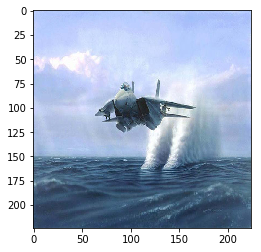

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(np.asarray(train_data['images'][81], dtype='uint8'))

In [18]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50

from models import vgg

from utils.losses import maad_from_deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


def biternion_vgg(image_height, image_width, n_channels, 
                  name='biternion_cnn', loss_type='cosine',
                  backbone_cnn_type='inception_resnet',
                  learning_rate=1.0e-3, fixed_kappa=1.0):

    #X_input = Input(shape=[image_height, image_width, n_channels], name='input_image')
    
    if backbone_cnn_type=='inception_resnet':
        backbone_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                                      input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)
        
    elif backbone_cnn_type=='densenet':
        backbone_model = DenseNet169(weights=None, include_top=False, 
                              input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    
    #     vgg_img = vgg.vgg_model(final_layer=False,
    #                             image_height=image_height,
    #                             image_width=image_width,
    #                             n_channels=n_channels)(X_input)

    theta_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean')(Dense(2, activation='linear')(x))
    
    theta_kappa =  Lambda(lambda x: K.abs(x), name='theta_kappa')(Dense(1, activation='linear')(x))
        
    y_pred = concatenate([theta_mean, theta_kappa])
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        if loss_type=='cosine':
            loss = cosine_loss_tf(theta_target, theta_mean)
            
        elif loss_type=='likelihood':
            loss = -von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
             
        return loss
    
    model = Model(backbone_model.input, y_pred, name=name)
    
    opt = Adam(lr=learning_rate)
    model.compile(optimizer=opt, loss=_loss)
    
    return model

def finetune_kappa(model, x, y_bit, max_kappa=10.0, step=0.1, verbose=False):
    ytr_preds_bit = model.predict(x)[:, 0:2]
    kappa_vals = np.arange(0, max_kappa, step)
    log_likelihoods = np.zeros(kappa_vals.shape)
    for i, kappa_val in enumerate(kappa_vals):
        kappa_preds = np.ones([x.shape[0], 1]) * kappa_val
        log_likelihoods[i] = np.mean(von_mises_log_likelihood_np(y_bit, ytr_preds_bit, kappa_preds))
        if verbose:
            print("kappa: %f, log-likelihood: %f" % (kappa_val, log_likelihoods[i]))
    max_ix = np.argmax(log_likelihoods)
    fixed_kappa_value = kappa_vals[max_ix]
    print("best kappa : %f" % fixed_kappa_value)
    return fixed_kappa_value

from scipy import stats
from utils.losses import maad_from_deg

def evaluate_model(model, images, y_target, data_part, loss_type='cosine', fixed_kappa=None):
    
    y_pred = model.predict(images, batch_size=32, verbose=1)
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]
        
        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    theta_target = _unpack_target(y_target)
    theta_mean, theta_kappa = _unpack_preds(y_pred) 
    
    preds_theta = bit2deg(theta_mean)
    gt_theta = bit2deg(theta_target)
    aads = maad_from_deg(gt_theta, preds_theta)
    theta_maad = np.mean(aads)
    theta_maad_sem = stats.sem(aads)
    print("MAAD (%s): %f±%f" %(data_part, theta_maad, theta_maad_sem))
    if fixed_kappa is not None:
        theta_kappa = np.ones(theta_kappa.shape)*fixed_kappa
    theta_lls = von_mises_log_likelihood_np(theta_target, theta_mean, theta_kappa)
    theta_ll = np.mean(theta_lls)
    theta_ll_sem = stats.sem(theta_lls)
    print("Log-likelihood (%s): %f±%f" %(data_part, theta_ll, theta_ll_sem))
    
    return

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


def train_model(angle='azimuth', loss='cosine', n_epochs=10, lr=1.0e-3, batch_size=32):
    
    print("defining the model..")
    
    angle_key = angle+'_bit'
    
    model = biternion_vgg(image_height, image_width, n_channels, 
                          loss_type=loss, learning_rate=lr)
    
    ckpt_path = '../logs/%s_model_%s.ckpt' %(angle, loss)
    
    model.save_weights(ckpt_path)
    
    early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    print("training on %s angle, loss type: %s" % (angle.upper(), loss.upper()) )
    model.fit(train_data['images'], train_data[angle_key],
              validation_data=[val_data['images'], val_data[angle_key]],
              epochs=n_epochs,
              batch_size=batch_size,
              callbacks=[early_stop_cb, model_ckpt])

    model.load_weights(ckpt_path)
    
    if loss=='cosine':
        print("finetuning kappa value..")
        fixed_kappa = finetune_kappa(model=model, 
                                     x=val_data['images'], 
                                     y_bit=val_data[angle_key], step=0.1, verbose=False)
    else:
        fixed_kappa = None
        
    print("training finished. Checkpoint path : %s" % ckpt_path)
    
    print("evaluating %s model.." % angle.upper())
    evaluate_model(model, train_data['images'], train_data[angle_key], 'train', fixed_kappa=fixed_kappa)
    evaluate_model(model, val_data['images'], val_data[angle_key], 'validation', fixed_kappa=fixed_kappa)
    evaluate_model(model, test_data['images'], test_data[angle_key], 'test', fixed_kappa=fixed_kappa)
    
    K.clear_session()
    
    return model, fixed_kappa

In [24]:
K.clear_session()
cosine_model, fixed_kappa = train_model(angle='azimuth', loss='cosine', n_epochs=100, lr=1.0e-3, batch_size=32)

defining the model..
training on AZIMUTH angle, loss type: COSINE
Train on 2528 samples, validate on 281 samples
Epoch 1/50
2528/2528 [==============================] - 55s 22ms/step - loss: 0.5099 - val_loss: 1.1396

Epoch 00001: val_loss improved from inf to 1.13958, saving model to ../logs/azimuth_model_cosine.ckpt
Epoch 2/50
2528/2528 [==============================] - 46s 18ms/step - loss: 0.3888 - val_loss: 0.6064

Epoch 00002: val_loss improved from 1.13958 to 0.60641, saving model to ../logs/azimuth_model_cosine.ckpt
Epoch 3/50
2528/2528 [==============================] - 46s 18ms/step - loss: 0.3567 - val_loss: 0.7164

Epoch 00003: val_loss did not improve
Epoch 4/50
2528/2528 [==============================] - 46s 18ms/step - loss: 0.3589 - val_loss: 0.7338

Epoch 00004: val_loss did not improve
Epoch 5/50
2528/2528 [==============================] - 47s 19ms/step - loss: 0.3347 - val_loss: 0.4447

Epoch 00005: val_loss improved from 0.60641 to 0.44468, saving model to ../log

In [149]:
K.clear_session()
model_likelihood, _ = train_model(angle='azimuth', loss='likelihood', n_epochs=200, lr=1.0e-3, batch_size=32)

defining the model..
training on AZIMUTH angle, loss type: LIKELIHOOD
Train on 2528 samples, validate on 281 samples
Epoch 1/200
2528/2528 [==============================] - 58s 23ms/step - loss: 1.6752 - val_loss: 50.2516

Epoch 00001: val_loss improved from inf to 50.25159, saving model to ../logs/azimuth_model_likelihood.ckpt
Epoch 2/200
2528/2528 [==============================] - 46s 18ms/step - loss: 1.2903 - val_loss: 69.0138

Epoch 00002: val_loss did not improve
Epoch 3/200
2528/2528 [==============================] - 46s 18ms/step - loss: 1.2125 - val_loss: 1.3488

Epoch 00003: val_loss improved from 50.25159 to 1.34880, saving model to ../logs/azimuth_model_likelihood.ckpt
Epoch 4/200
2528/2528 [==============================] - 46s 18ms/step - loss: 1.0381 - val_loss: 2.6343

Epoch 00004: val_loss did not improve
Epoch 5/200
2528/2528 [==============================] - 46s 18ms/step - loss: 0.8902 - val_loss: 1.3324

Epoch 00005: val_loss improved from 1.34880 to 1.33243, s

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import vonmises

def plot_prediction(img, target, pred, kappa=1.0, pdf=None):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(np.asarray(img, dtype='uint8'))
    axs[0].axis('off')
    
    def _plot_vm_pdf(ax):
        x = np.arange(0, 2*np.pi, 0.01)
        xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
        xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks_labels)
        #if pdf is None:
        pdf = vonmises.pdf(x, loc=pred, kappa=kappa)
        ax.plot(x, pdf) 
        ax.axvline(target, c='red', label='ground truth')
        ax.axvline(pred, c='blue', label='predicted mean')
        ax.set_xlim((0, 2*np.pi))
        ax.set_ylim(0, 1.0)
        ax.legend(loc=1)
        
    _plot_vm_pdf(axs[1])
    
    fig.show()
    
    return

In [30]:
def detection_demo(imgs, target, model, 
                   fixed_kappa=False, kappa_value=1.0,
                   n_to_show=50,  random=False):
    
    if random:
        frames = np.random.choice(target.shape[0], n_to_show, replace=False)
    else:
        frames = range(0, n_to_show)
    
    preds = model.predict(imgs[frames])
    mus = np.deg2rad(bit2deg(preds[:, 0:2]))
    kappas = preds[:, 2:3]
    xvals = np.arange(0, 2*np.pi, 0.01)
   
    for i, fid in enumerate(frames):
        if fixed_kappa:
            plot_prediction(imgs[fid], target[fid], mus[i], kappa_value)
        else:
            plot_prediction(imgs[fid], target[fid], mus[i], kappas[i])
        
    return

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


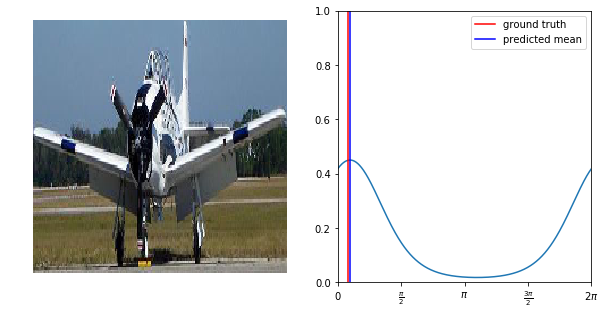

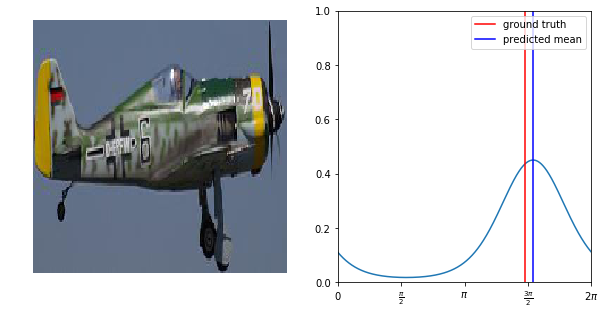

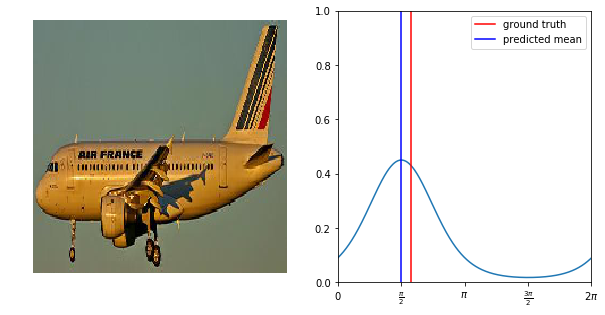

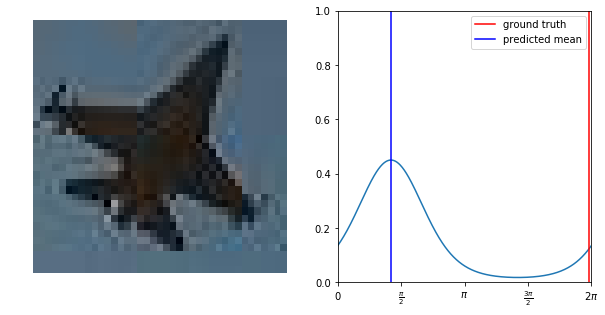

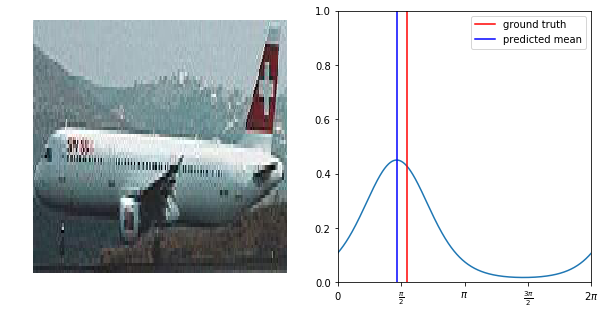

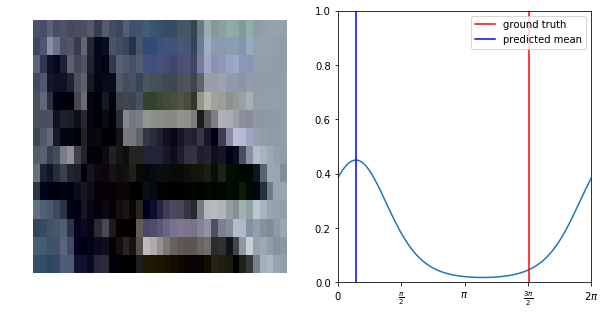

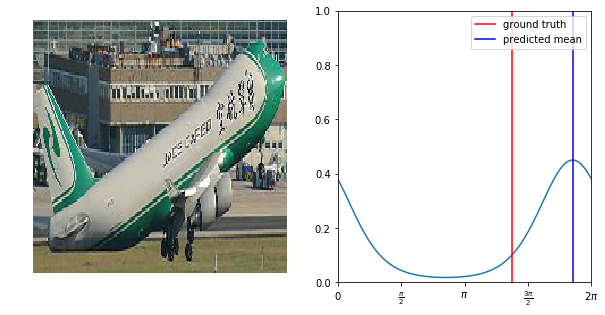

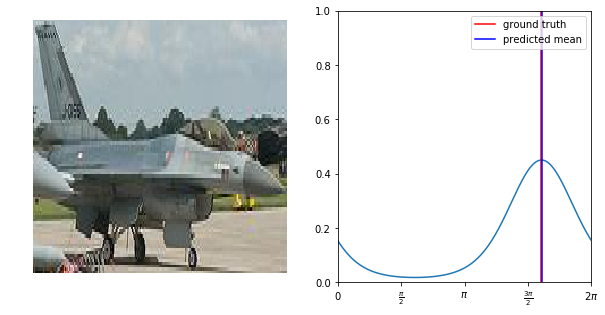

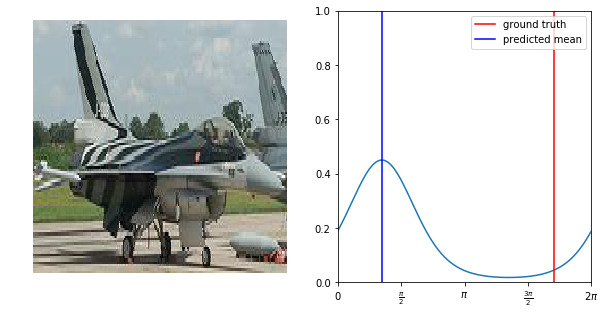

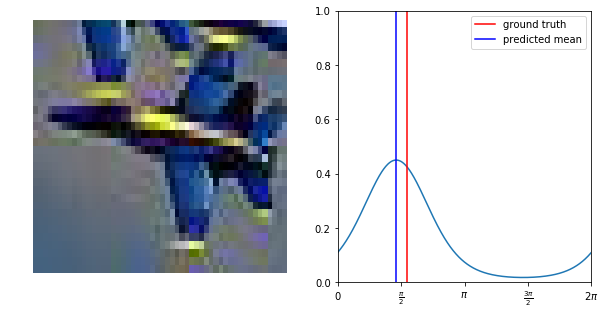

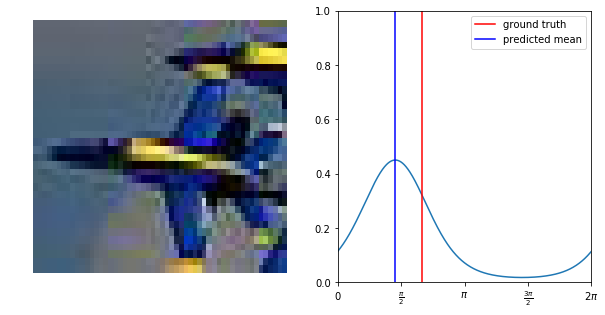

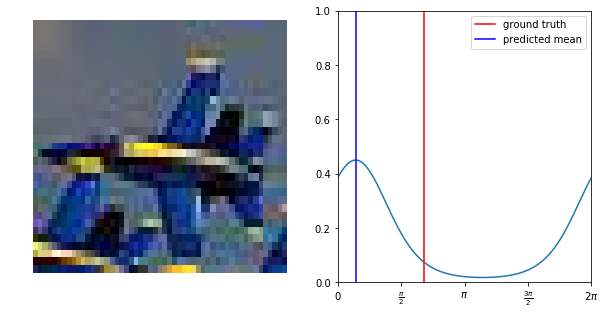

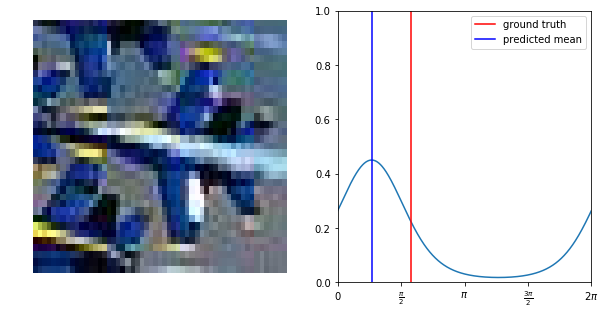

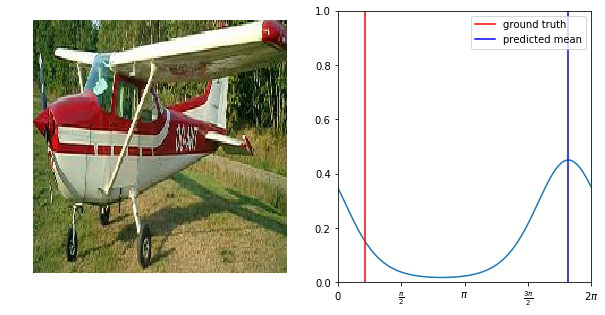

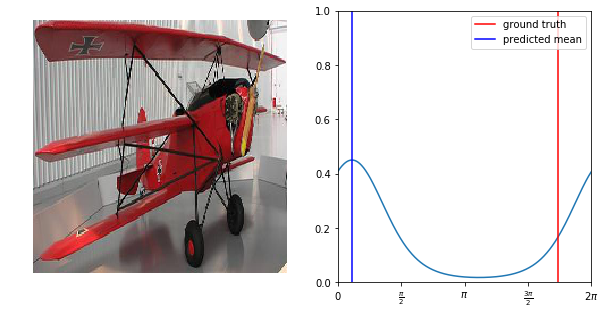

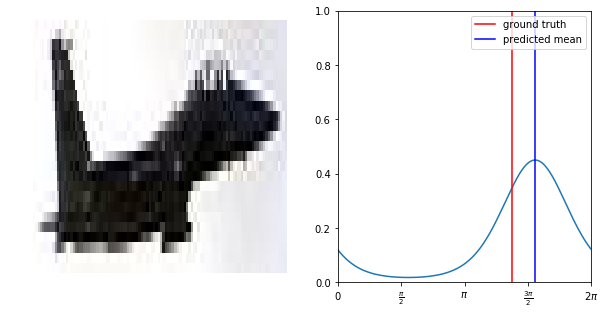

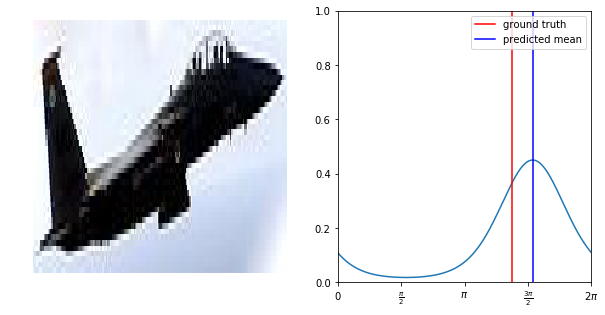

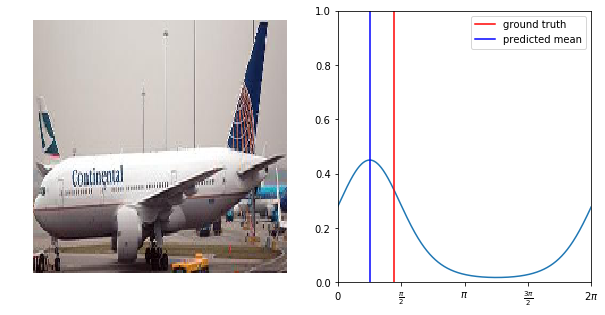

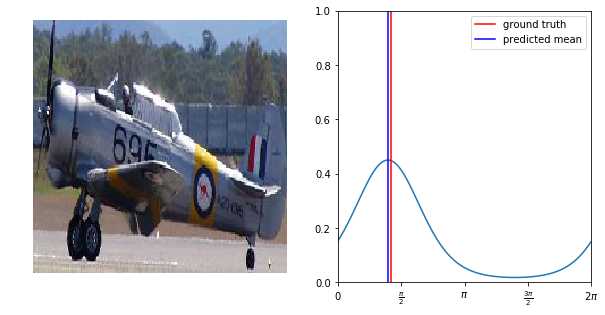

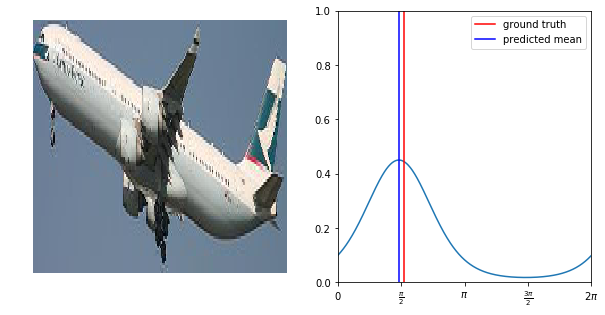

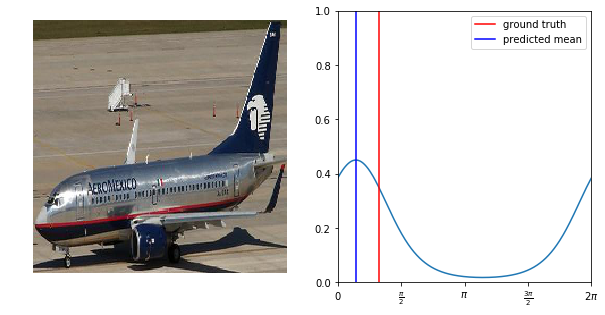

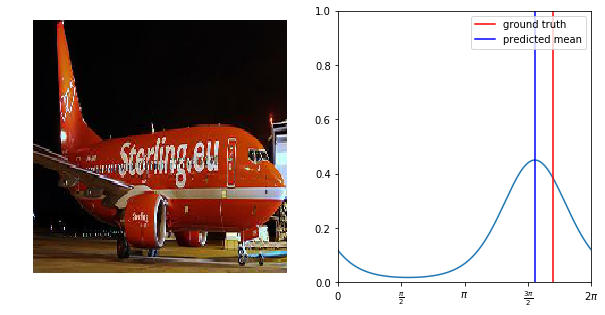

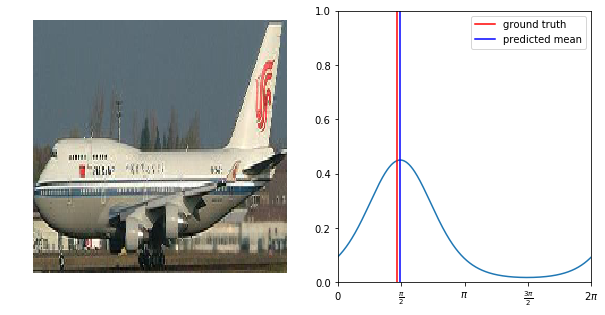

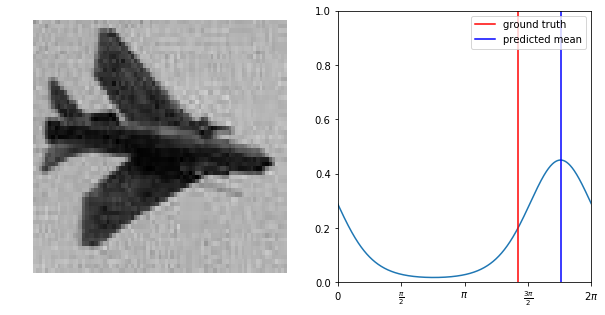

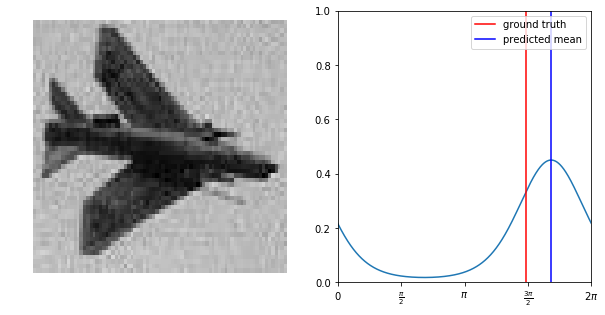

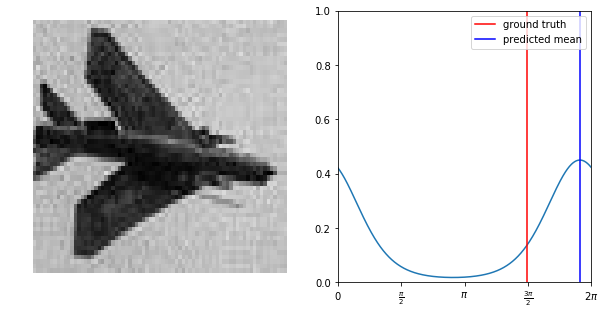

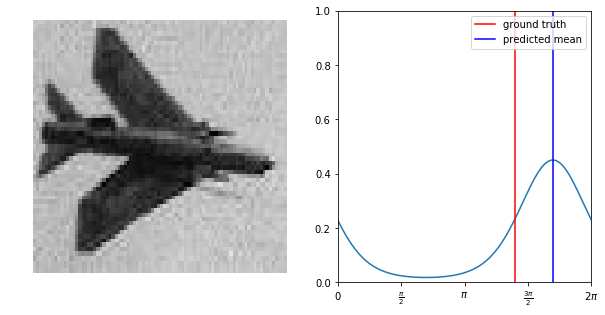

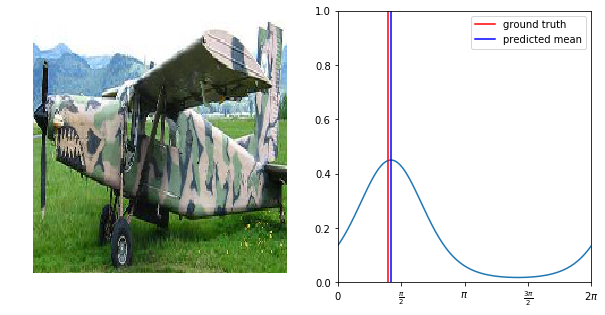

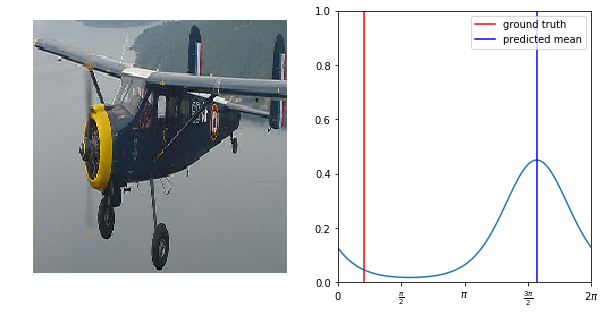

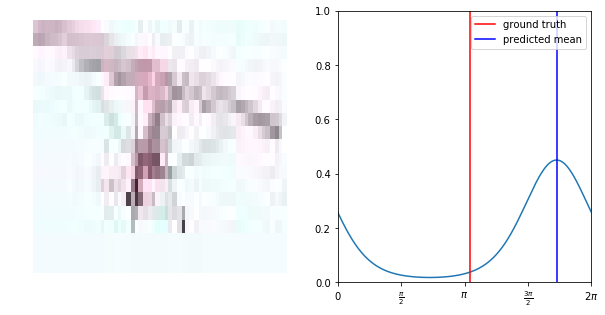

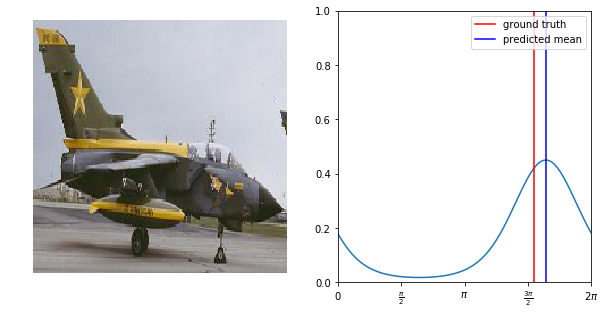

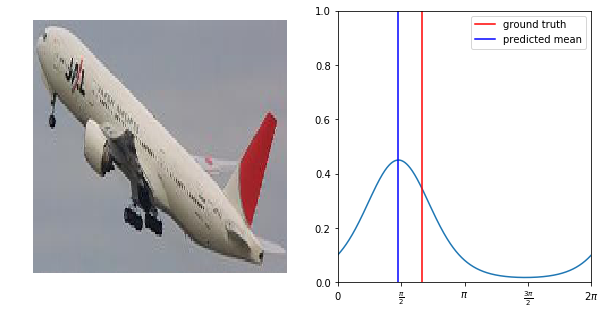

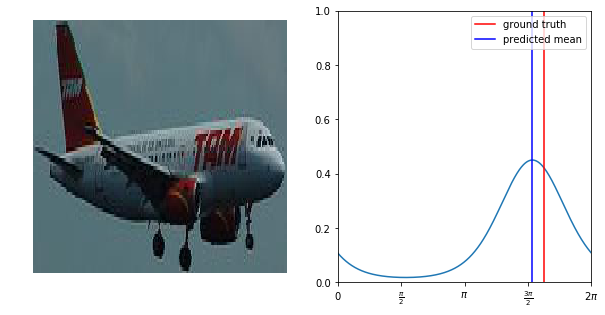

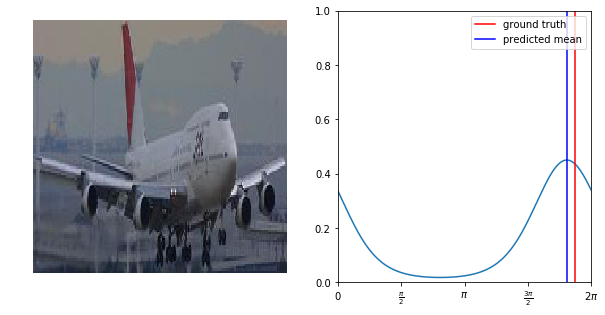

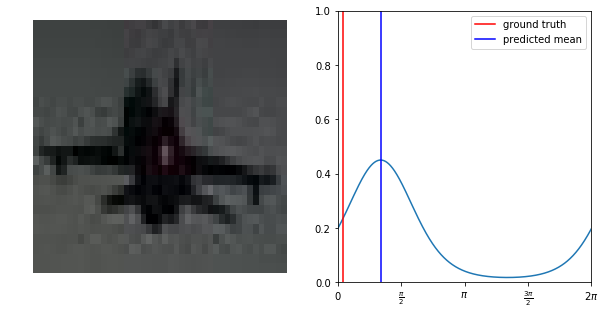

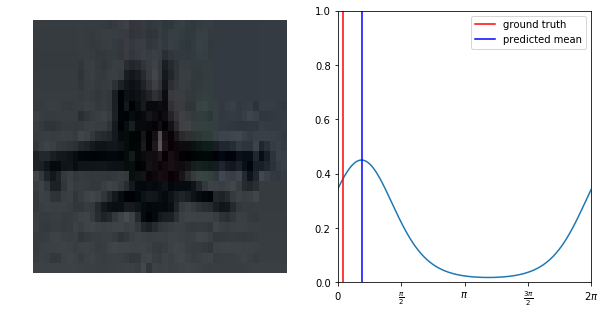

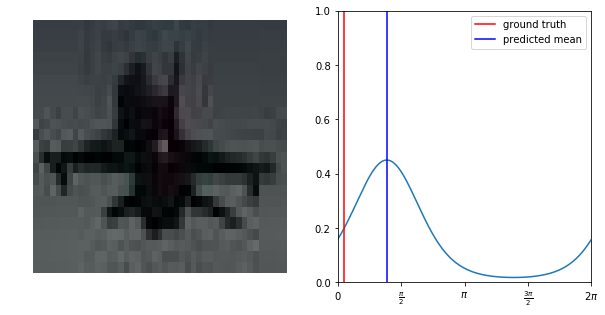

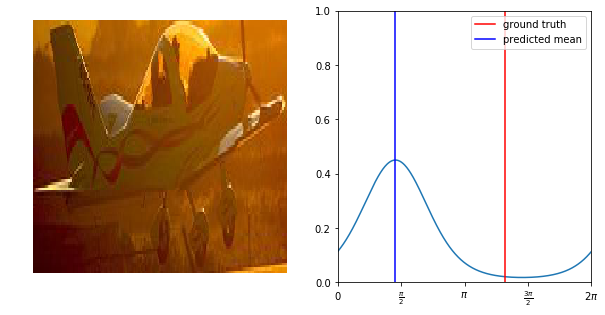

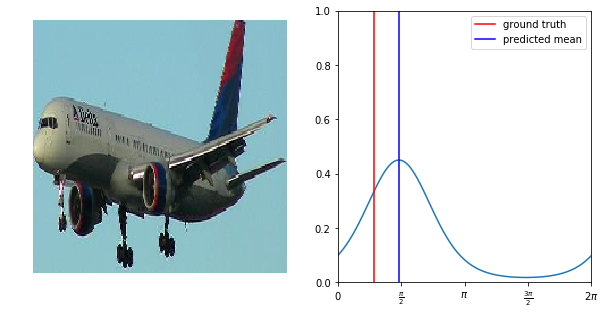

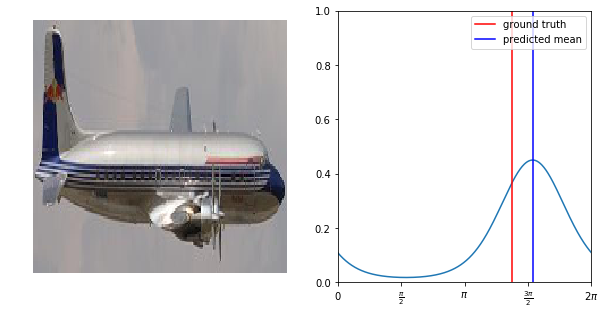

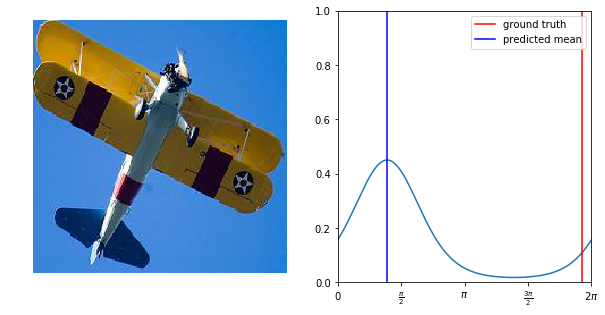

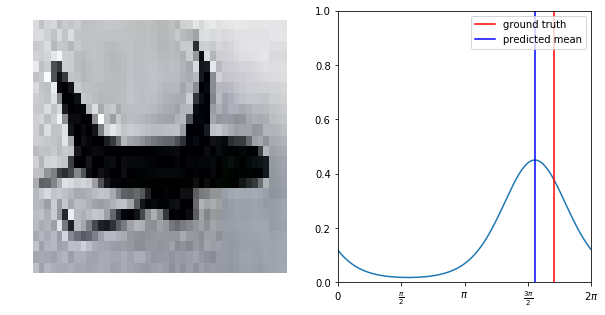

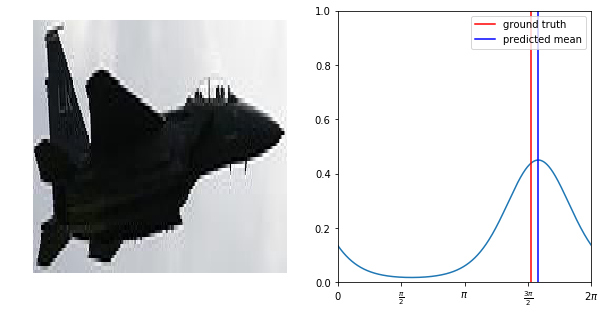

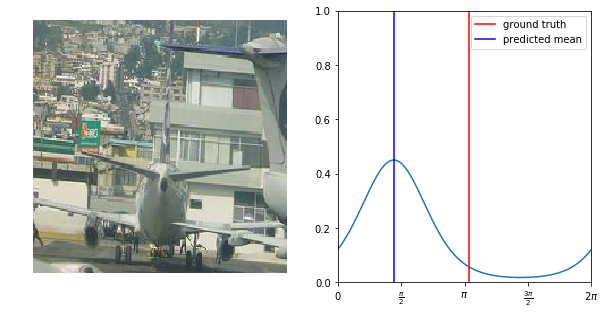

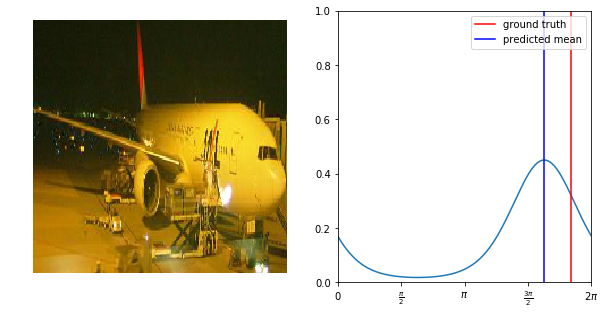

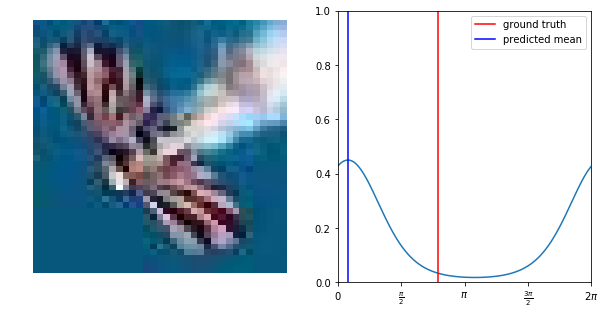

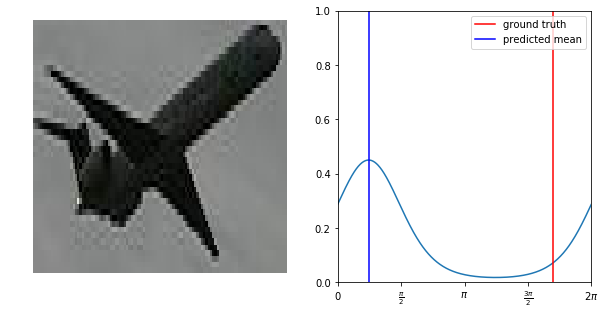

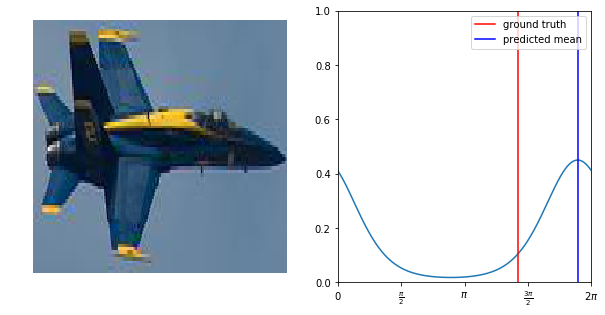

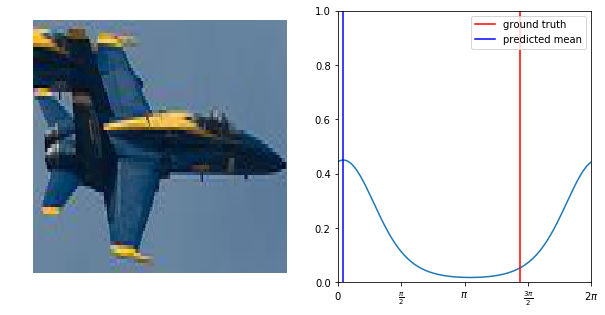

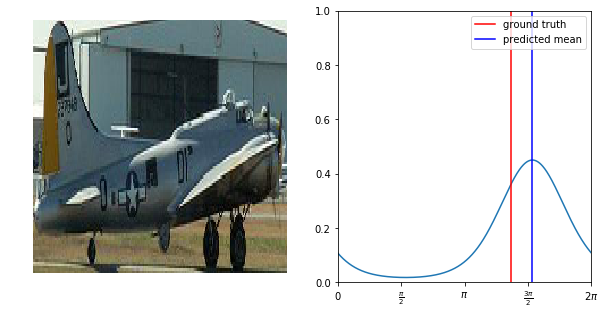

In [33]:
cosine_model = biternion_vgg(image_height, image_width, n_channels, loss_type='cosine')
cosine_model.load_weights('../logs/azimuth_model_cosine.ckpt')

detection_demo(imgs=test_data['images'], target=np.deg2rad(test_data['azimuth_deg']), 
               model=cosine_model, fixed_kappa=True,
               kappa_value=fixed_kappa, 
               n_to_show=50, random=False)

In [35]:
predicted_azimuth = likelihood_model.predict(test_data['images'])

In [57]:
rfc_predictions = '/lustre/home/sprokudin/RenderForCNN/view_estimation/vp_test_results_backup/aeroplane_pred_view.txt'
render_for_cnn_predictions = np.loadtxt(rfc_predictions, delimiter=' ')

In [59]:
rfc_azimuth = render_for_cnn_predictions[:, 0]

In [49]:
np.mean(maad_from_deg(bit2deg(predicted_azimuth[:, 0:2]), bit2deg(test_data['azimuth_bit'])))

34.845542658025565

In [19]:
vgg.vgg_model()

In [61]:
np.mean(maad_from_deg(rfc_azimuth, bit2deg(test_data['azimuth_bit'])))

26.26909090909091

In [43]:
bit2deg(predicted_azimuth[:, 0:2]).shape

(275,)

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


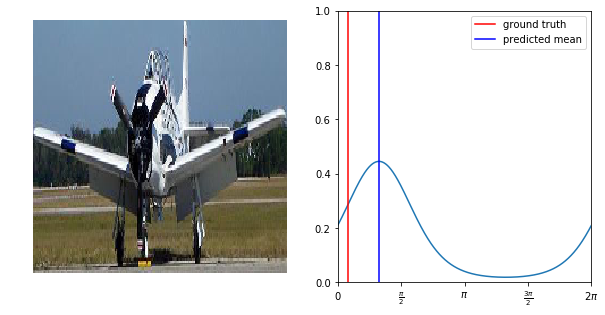

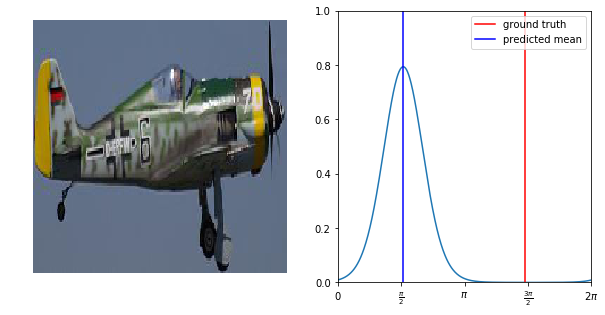

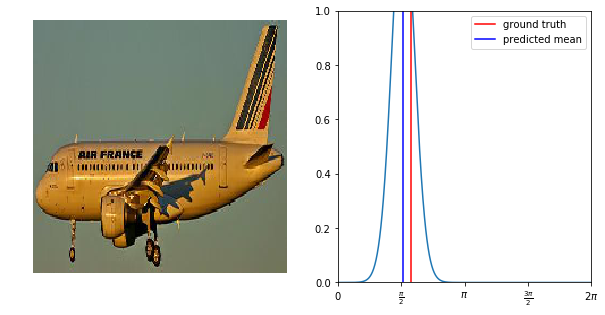

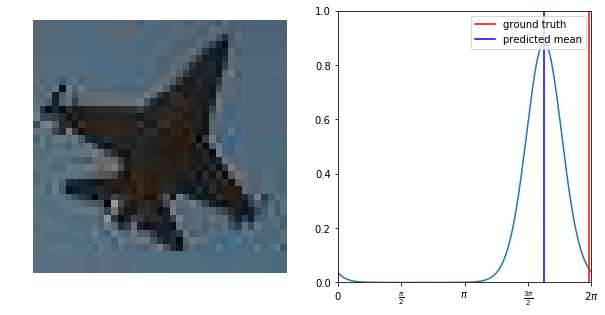

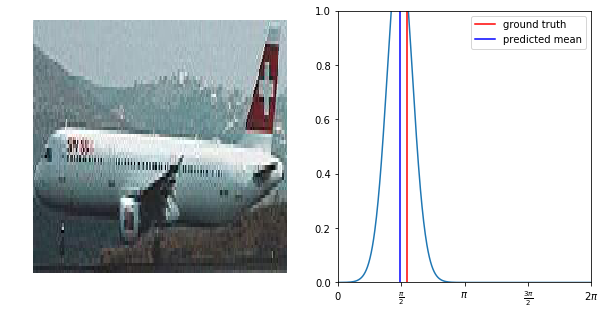

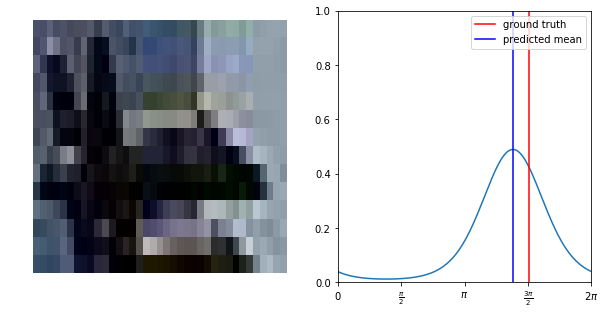

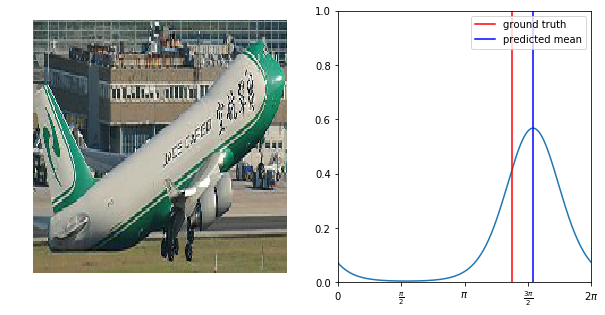

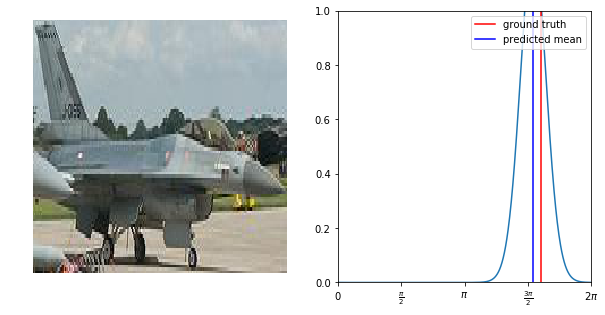

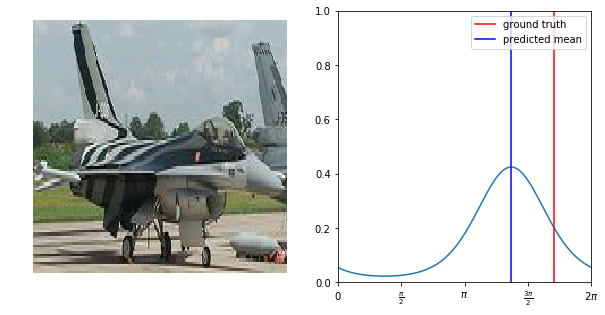

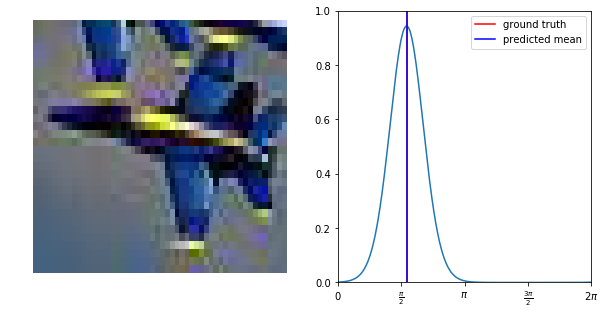

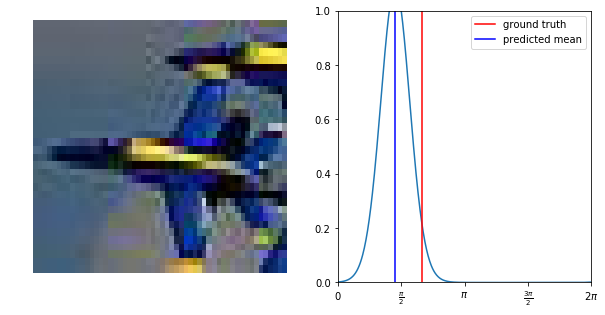

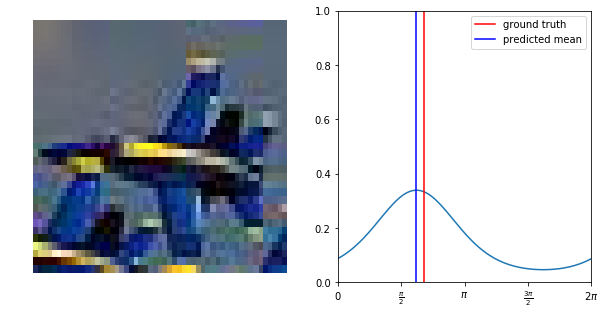

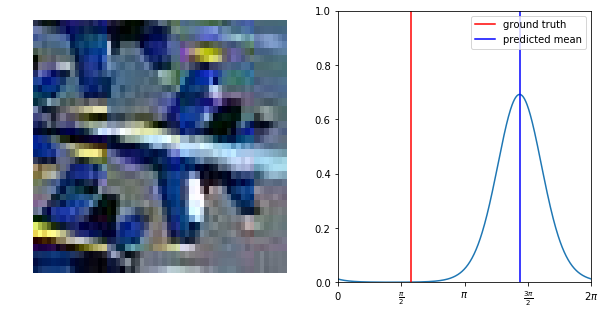

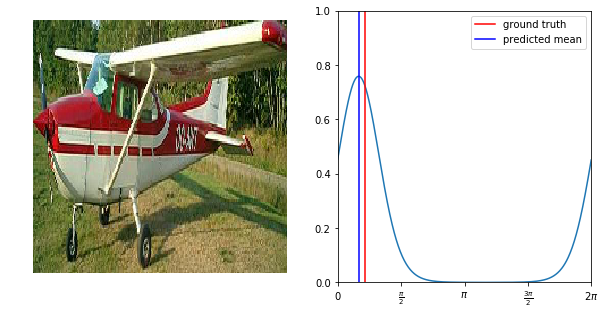

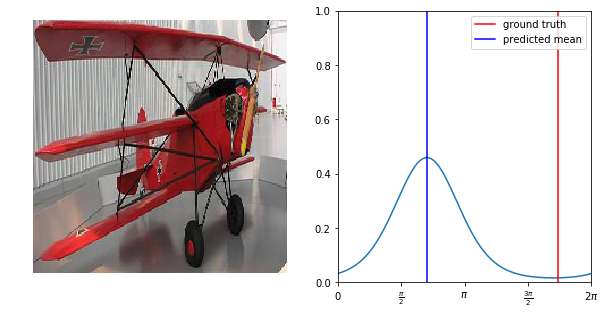

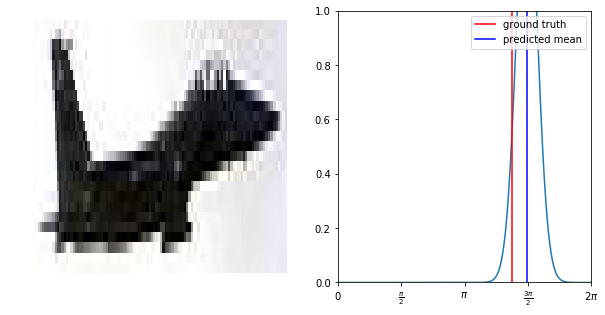

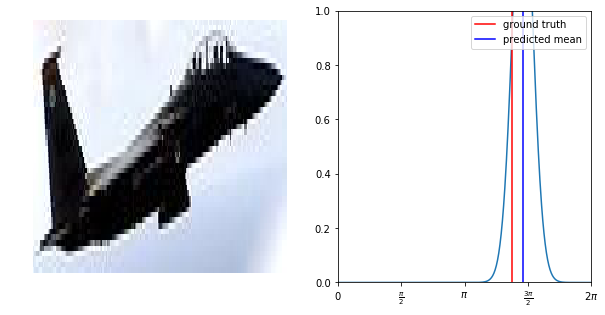

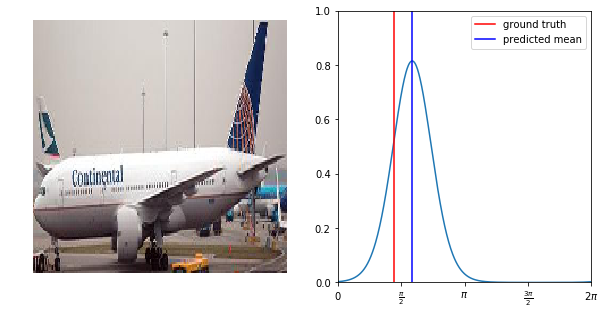

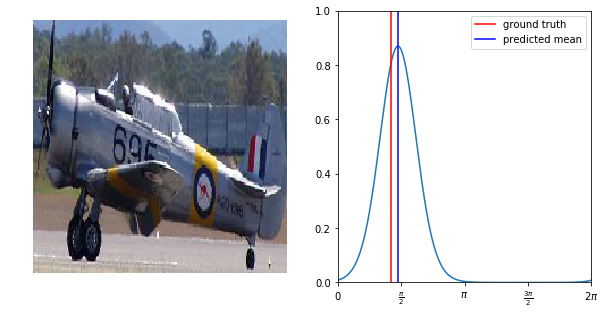

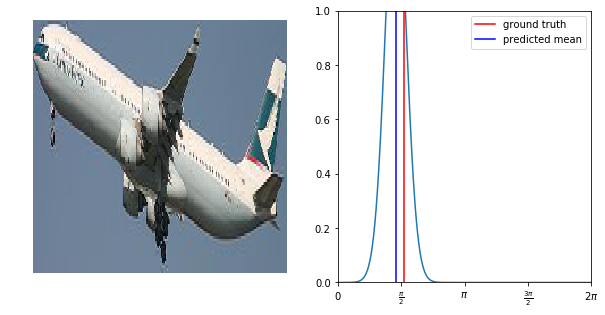

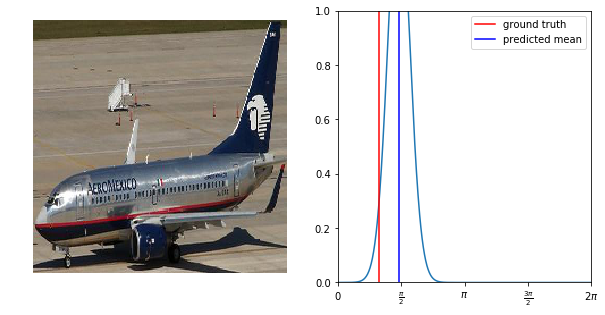

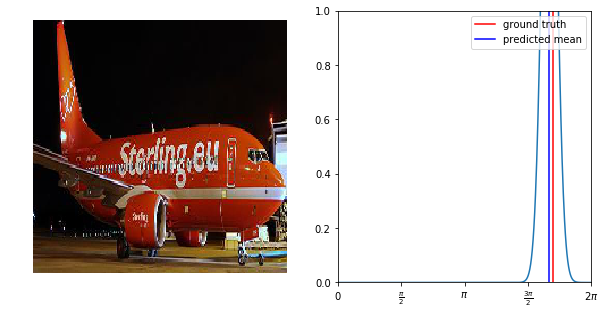

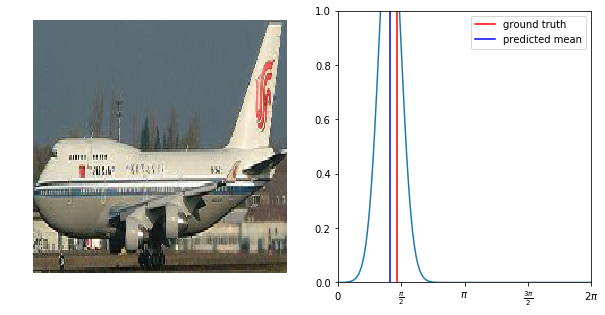

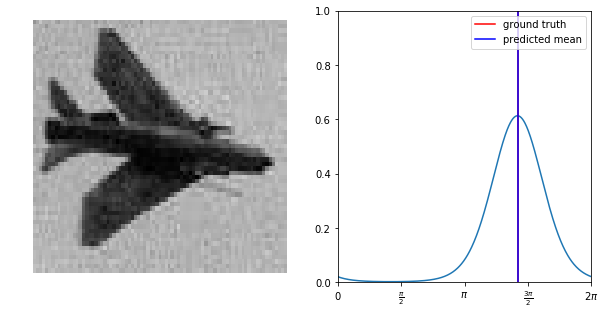

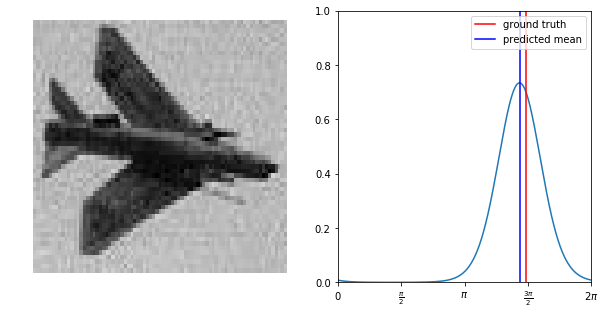

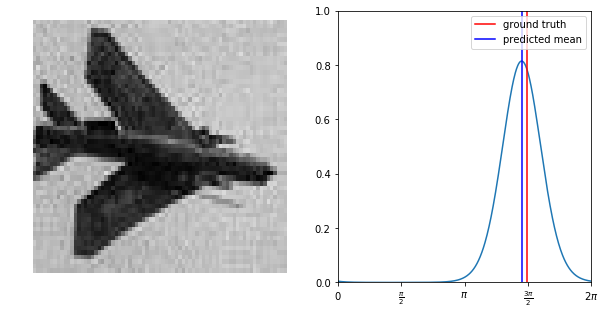

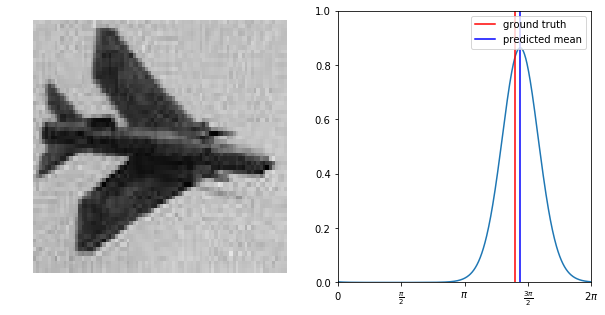

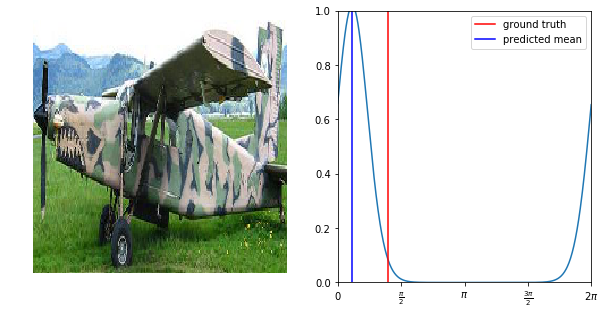

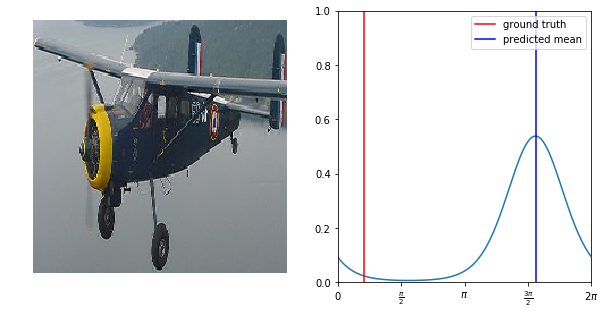

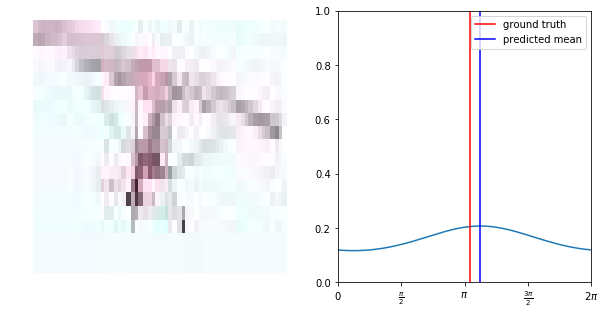

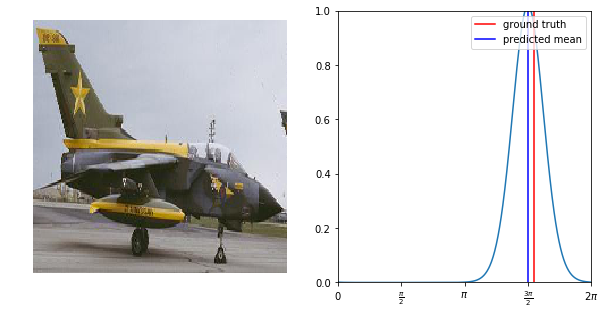

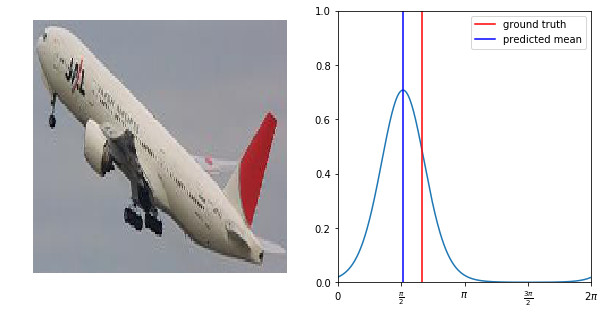

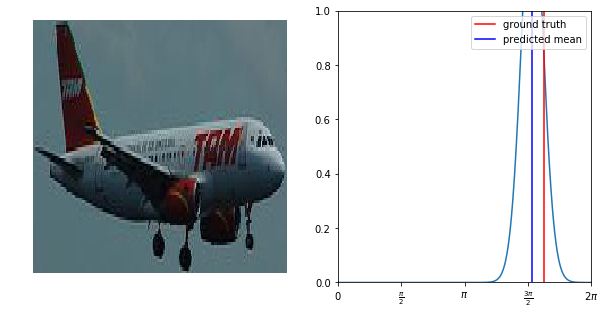

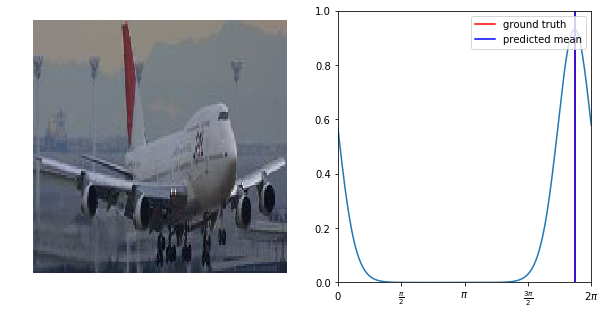

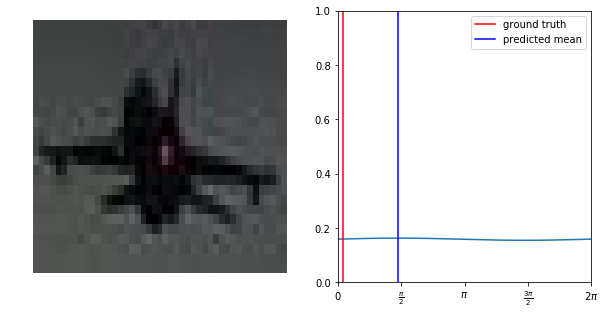

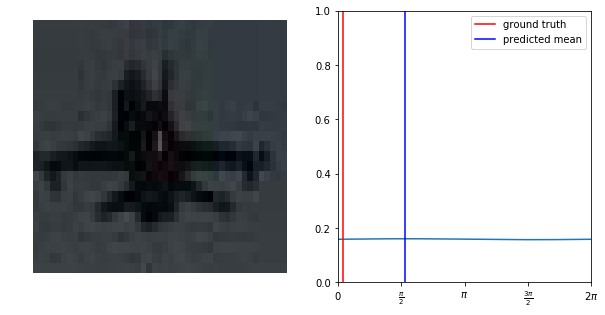

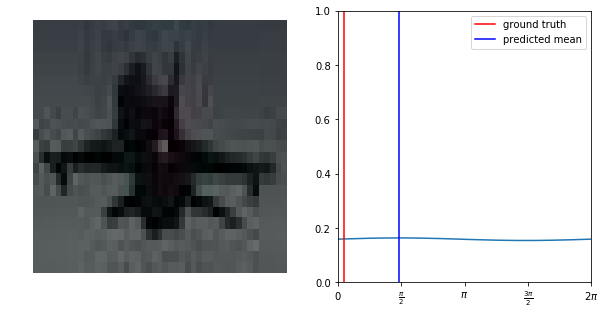

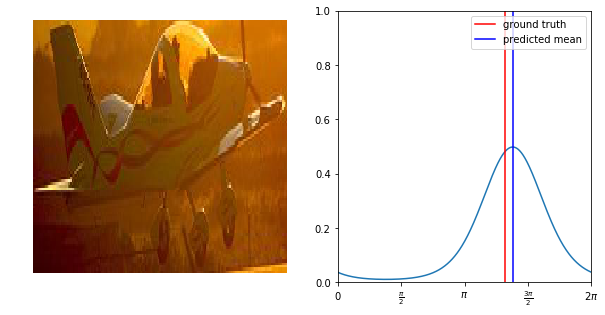

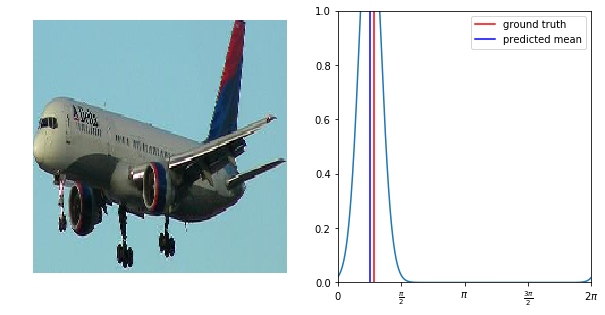

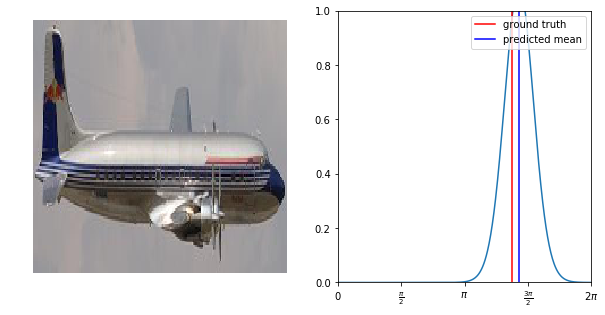

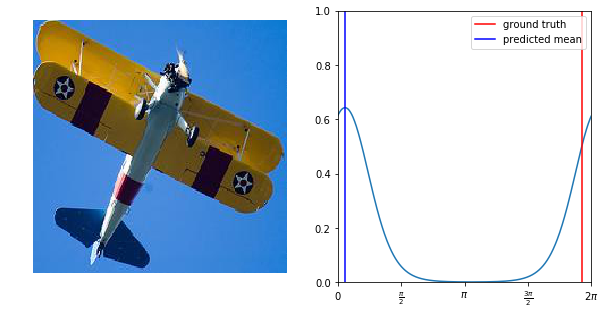

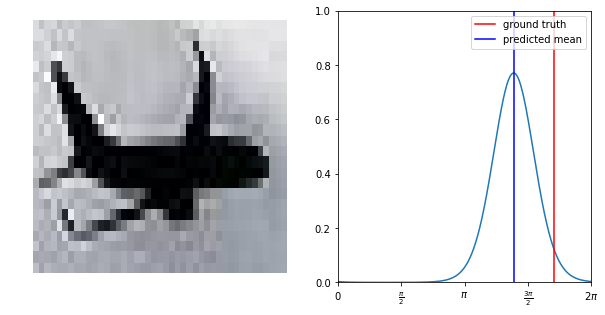

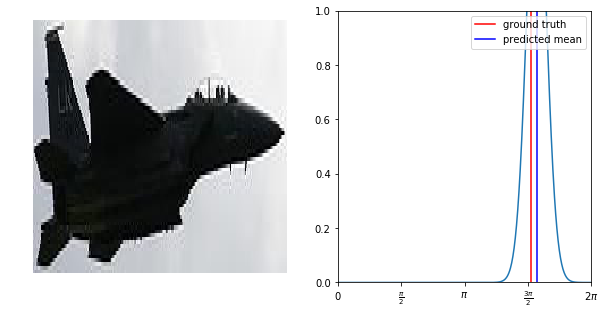

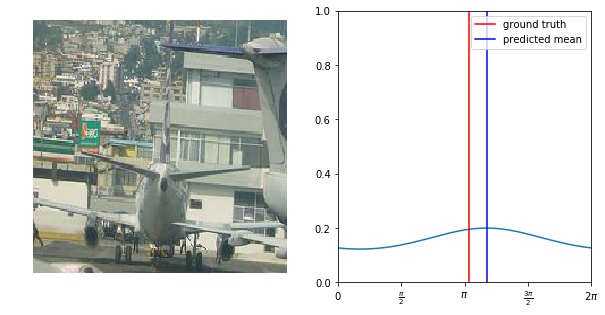

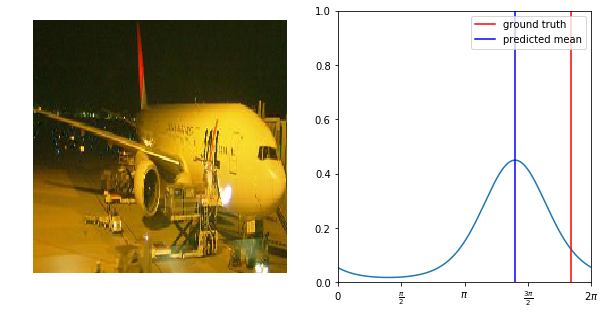

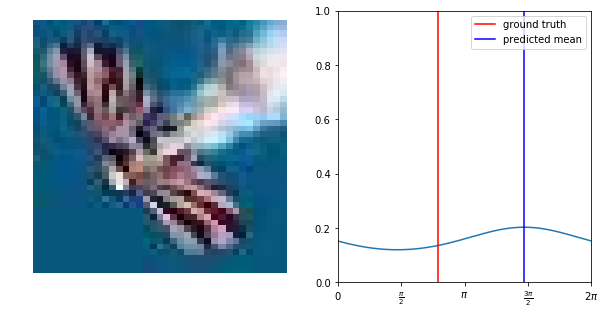

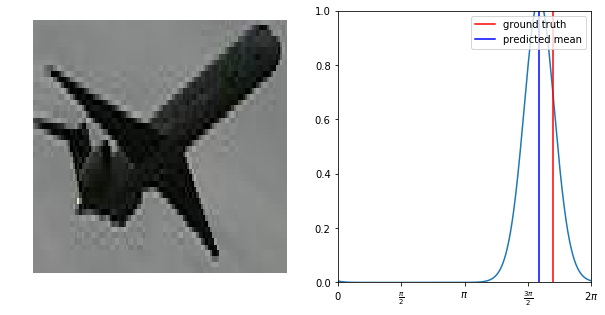

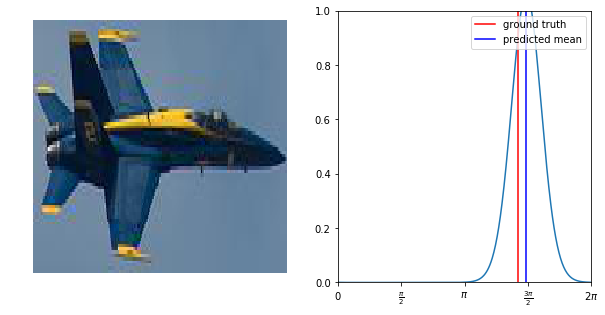

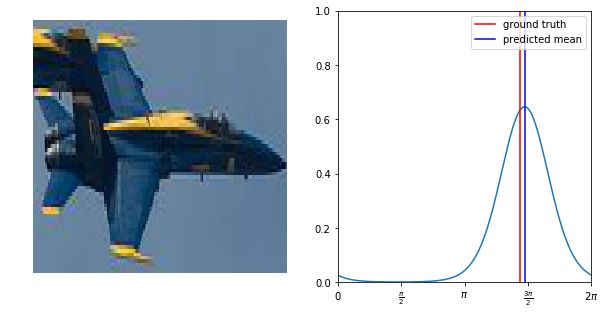

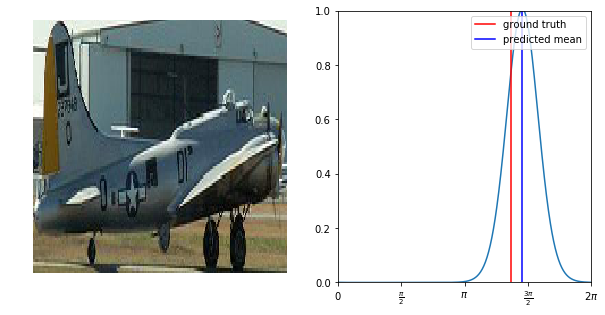

In [34]:
likelihood_model = biternion_vgg(image_height, image_width, n_channels, loss_type='likelihood')
likelihood_model.load_weights('../logs/azimuth_model_likelihood.ckpt')

detection_demo(imgs=test_data['images'], target=np.deg2rad(test_data['azimuth_deg']), 
               model=likelihood_model, n_to_show=50, random=False)

In [ ]:
np.savetxt('../logs/aeroplane_pred_view.txt',  aeroplane_preds.astype('int'), fmt='%i') 

In [13]:
def biternion_vae(image_height, image_width, n_channels, 
                  name='biternion_cnn', loss_type='cosine',
                  backbone_cnn_type='inception_resnet',
                  learning_rate=1.0e-3, fixed_kappa=1.0):

    #X_input = Input(shape=[image_height, image_width, n_channels], name='input_image')
    
    if backbone_cnn_type=='inception_resnet':
        backbone_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                                      input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)
        
    elif backbone_cnn_type=='densenet':
        backbone_model = DenseNet169(weights=None, include_top=False, 
                              input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)

    def _sample_noise(x):
        return K.random_normal(shape=K.shape(x[:, 0:8]), mean=0., stddev=1.0)
    
    noise = Lambda(_sample_noise, name="noise_sample")(x)
    x = concatenate([x, noise])
    
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    
    theta_mean = Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean')(Dense(2, activation='linear')(x))
    
    theta_kappa =  Lambda(lambda x: K.abs(x), name='theta_kappa')(Dense(1, activation='linear')(x))
        
    y_pred = concatenate([theta_mean, theta_kappa])
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        if loss_type=='cosine':
            loss = cosine_loss_tf(theta_target, theta_mean)
            
        elif loss_type=='likelihood':
            loss = -von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
             
        return loss
    
    model = Model(backbone_model.input, y_pred, name=name)
    
    opt = Adam(lr=learning_rate)
    model.compile(optimizer=opt, loss=_loss)
    
    return model

In [14]:
K.clear_session()
bivae = biternion_vae(image_height, image_width, n_channels, 
                      loss_type='likelihood', learning_rate=1.0e-4)

In [1]:
from models import vgg

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine')

ImportError: Traceback (most recent call last):
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/sprokudin/biternionnet/py_env/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [184]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#K.clear_session()
ckpt_path = '../logs/azimuth_vae.ckpt' 
angle = 'azimuth'
angle_key = angle+'_bit'

#biternion_vae.save_weights(ckpt_path)

early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

bivae.fit(train_data['images'], train_data[angle_key],
          validation_data=[val_data['images'], val_data[angle_key]],
          epochs=10,
          batch_size=32,
          callbacks=[early_stop_cb, model_ckpt])

bivae.load_weights(ckpt_path)

Train on 2247 samples, validate on 562 samples
Epoch 1/10
2247/2247 [==============================] - 115s 51ms/step - loss: 0.6196 - val_loss: 1.5189

Epoch 00001: val_loss improved from inf to 1.51888, saving model to ../logs/azimuth_vae.ckpt
Epoch 2/10
2247/2247 [==============================] - 115s 51ms/step - loss: 0.4926 - val_loss: 1.6180

Epoch 00002: val_loss did not improve
Epoch 3/10
2247/2247 [==============================] - 115s 51ms/step - loss: 0.3329 - val_loss: 1.8291

Epoch 00003: val_loss did not improve
Epoch 4/10
2247/2247 [==============================] - 115s 51ms/step - loss: 0.1851 - val_loss: 1.5217

Epoch 00004: val_loss did not improve
Epoch 5/10
2247/2247 [==============================] - 115s 51ms/step - loss: 0.1385 - val_loss: 1.7463

Epoch 00005: val_loss did not improve
Epoch 6/10
2247/2247 [==============================] - 115s 51ms/step - loss: -0.0201 - val_loss: 1.0236

Epoch 00006: val_loss improved from 1.51888 to 1.02363, saving model to

In [11]:
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

In [185]:
vae_preds = bivae.predict(train_data['images'][0:10])
vae_preds1 = bivae.predict(train_data['images'][0:10])
vae_preds2 = bivae.predict(train_data['images'][0:10])

In [186]:
bit2deg(vae_preds1[:, 0:2])

array([278.2521  , 341.25226 ,  42.73645 , 212.92383 ,  55.25049 ,
       249.07787 , 288.41733 ,  51.944885, 291.53912 ,   7.59729 ],
      dtype=float32)

In [188]:
bit2deg(vae_preds2[:, 0:2])

array([278.1497  , 340.9263  ,  42.20575 , 218.58795 ,  55.26419 ,
       249.66507 , 288.4512  ,  53.173523, 291.80756 ,   7.910492],
      dtype=float32)

In [190]:
bit2deg(vae_preds[:, 0:2])

array([278.11356  , 340.80054  ,  41.766968 , 218.4258   ,  54.90985  ,
       248.23105  , 288.72705  ,  52.86035  , 291.55945  ,   7.8191833],
      dtype=float32)